In [1]:
# Import necessary functionality
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True) # Display setting for printed values

In [2]:
# Define indices for each body region (I)
# This allows regions to be indexed with intuitive english language, as opposed to a number
# 1 (one) is subtracted from each index since they are enumerated starting at 1 in the original literature, but Python indexes iterables beginning at 0
head = 1-1
trunk = 2-1
arms = 3-1
coolarms = 4-1
hands = 5-1
legs = 6-1
feet = 7-1

## Define indices for each layer node (N)
# This allows nodes to be indexed with intuitive english language, as opposed to a number
# 1 (one) is subtracted from each index since they are enumerated starting at 1 in the original literature, but Python indexes iterables beginning at 0
headcore = 1-1
headmuscle = 2-1
headfat = 3-1
headskin = 4-1
trunkcore = 5-1
trunkmuscle = 6-1
trunkfat = 7-1
trunkskin = 8-1
armscore = 9-1
armsmuscle = 10-1
armsfat = 11-1
armsskin = 12-1
coolarmscore = 13-1
coolarmsmuscle = 14-1
coolarmsfat = 15-1
coolarmsskin = 16-1
handscore = 17-1
handsmuscle = 18-1
handsfat = 19-1
handsskin = 20-1
legscore = 21-1
legsmuscle = 22-1
legsfat = 23-1
legsskin = 24-1
feetcore = 25-1
feetmuscle = 26-1
feetfat = 27-1
feetskin = 28-1
centralblood = 29-1

## Define arrays containing indices for different node types
coreNs = [headcore,trunkcore,armscore,coolarmscore,handscore,legscore,feetcore]
muscleNs = [headmuscle,trunkmuscle,armsmuscle,coolarmsmuscle,handsmuscle,legsmuscle,feetmuscle]
fatNs = [headfat,trunkfat,armsfat,coolarmsfat,handsfat,legsfat,feetfat]
skinNs = [headskin,trunkskin,armsskin,coolarmsskin,handsskin,legsskin,feetskin]

In [3]:
dt = 0.0005    # time step [h]
t_end = 2.5   # end time [h]

# Time array
ts = np.arange(0,t_end,dt)

# Initialize arrays storing key simulation values
# Meaning for each variable outlined in Table 1 of Stolwijk (1971)
C = np.zeros(29)
T = np.zeros((len(ts),29))
F = np.zeros((len(ts),29))
HF = np.zeros((len(ts),29))
TC = np.zeros(29)
TD = np.zeros((len(ts),29))
QB = np.zeros(29)
Q = np.zeros((len(ts),29))
EB = np.zeros(29)
E = np.zeros((len(ts),29))
EMASS = np.zeros((len(ts),29))
AC = np.zeros((len(ts),29)) # Combined radiative and convective losses for ease of presentation
COOLING = np.zeros(len(ts)) # New value used to store extracted heat
BFB = np.zeros(29)
BF = np.zeros((len(ts),29))
BC = np.zeros((len(ts),29))
HC = np.zeros(7)
S = np.zeros(7)
HR = np.zeros(7)
H = np.zeros((len(ts),7))
P = np.array([6.5, 9.2, 12.8, 17.5, 23.8, 31.8, 41.2, 55.3, 71.9, 92.5])
TforP = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
PSKIN = np.zeros((len(ts),7))

## Define arrays containing indices for different node types
# This simplifies indexing of multiple nodes at the same time
Cloi = np.zeros(7)
Fcl = np.zeros((len(ts),7))
Facl = np.zeros(7)
Cloe = np.zeros(7)
Fpcl = np.zeros((len(ts),7))
EMAX = np.zeros((len(ts),7))
SkBFmax = np.zeros(len(ts))

# Solar irradiation properties
VF = np.zeros(7) # solar area factors
alpha = np.zeros(7) # Absorptivity

In [4]:
## Creating vectors describing air velocity
# Pre-exercise period
PreV = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
PreV = np.broadcast_to(PreV,(int(35/60/dt),7)) # 35 minutes of minimal movement
# Warmup on stationary ergometer
WUV = np.array([0.19, 0.16, 0.22, 0.22, 0.15, 0.44, 1.00]) # Based on Direct N+G measurements (worked backwards to get equivalent speed)
WUV = np.broadcast_to(WUV,(int(6.5/60/dt),7)) # 5 minute stationary warmup + 1.5 minutes affixing cooling
# Studied exercise bout
V = np.array([10, 10, 10, 10, 10, 10, 10]) # Cycling at 10m/s
# V = np.array([0.19, 0.16, 0.22, 0.22, 0.15, 0.44, 1.00]) # For stationary ergometer bouts
V = np.broadcast_to(V,(len(ts)-len(PreV)-len(WUV),7)) #create 2d array with values for each body segment and time step
V = np.concatenate((PreV,WUV,V),axis=0) # Combine all simulation periods

#Air temperature
TAIR = 25*np.ones((int(30/60/dt))) # 30 minutes before entering chamber at 25C
TAIR = np.concatenate((TAIR,30*np.ones(len(ts) - len(TAIR)))) # 30C for remainder of bout (replace with desired value)

# Relative humidity
RH = 0.3*np.ones((int(30/60/dt))) # 30 minutes before entering chamber at 30%
RH = np.concatenate((RH,0.7*np.ones(len(ts) - len(RH)))) # 70% for remainder of bout (replace with desired value)
PAIR = RH*np.interp(TAIR, TforP, P) #Obtain partial vapout pressure

# Solar irradiation flux
s = np.zeros((int(41.5/60/dt))) # 41.5 minutes indoors with no sun
s = np.concatenate((s,(1000/1.163)*np.ones(len(ts)-len(s)))) # 1000W for remaining outdoor bout converted to kcal/hr/m^2 (replace with desired value)
TOp = np.zeros((len(ts),7)) # Initialize operative temperature

In [5]:
## Assign values to appropriate arrays based on Stolwijk unless specified

cooling_ratio = 0.055 # Note that 0.055 ratio is the ratio of the skin area covered by the blocks to the total arm area adjusted for the DRDC sample

# Thermal conductance values [kcal/C/h] 
TC[headcore] = 1.38; TC[headmuscle] = 11.4; TC[headfat] = 13.8

TC[trunkcore] = 1.37; TC[trunkmuscle] = 4.75; TC[trunkfat] = 19.80

TC[armscore] = 1.20*(1-cooling_ratio); TC[armsmuscle] = 8.90*(1-cooling_ratio); TC[armsfat] = 26.20*(1-cooling_ratio) # Removing cooled arm segment from arm

TC[coolarmscore] = 1.20*(cooling_ratio); TC[coolarmsmuscle] = 3.5*cooling_ratio/0.055; TC[coolarmsfat] = 2.3*cooling_ratio/0.055 # Adjusted as described in doc

TC[handscore] = 5.50; TC[handsmuscle] = 9.65; TC[handsfat] = 9.90

TC[legscore] = 9.0; TC[legsmuscle] = 12.4; TC[legsfat] = 64.0

TC[feetcore] = 14.0; TC[feetmuscle] = 17.7; TC[feetfat] = 14.1

# Heat capacitance [kcal/C]
C[headcore] = 2.22; C[headmuscle] = 0.33; C[headfat] = 0.22; C[headskin] = 0.24

C[trunkcore] = 9.82; C[trunkmuscle] = 16.15; C[trunkfat] = 4.25; C[trunkskin] = 1.21

C[armscore] = 1.41*(1-cooling_ratio); C[armsmuscle] = 3.04*(1-cooling_ratio); C[armsfat] = 0.58*(1-cooling_ratio); C[armsskin] = 0.43*(1-cooling_ratio) # Removing cooled arm segment from arm

C[coolarmscore] = 1.41*(cooling_ratio); C[coolarmsmuscle] = 3.04*(cooling_ratio); C[coolarmsfat] = 0.01; C[coolarmsskin] = 0.013

C[handscore] = 0.14; C[handsmuscle] = 0.06; C[handsfat] = 0.09; C[handsskin] = 0.17

C[legscore] = 4.24; C[legsmuscle] = 9.17; C[legsfat] = 1.43; C[legsskin] = 1.08

C[feetcore] = 0.23; C[feetmuscle] = 0.06; C[feetfat] = 0.13; C[feetskin] = 0.22

C[centralblood] = 2.25

C = C*0.904 # Adjusting values for bodyweight of DRDC sample
C[coolarmsfat] = 0.01; C[coolarmsskin] = 0.013

# Basal evaporative losses [kcal/h]
EB[headskin] = 0.63
EB[trunkcore] = 9.00
EB[trunkskin] = 3.25
EB[armsskin] = 1.20*(1-cooling_ratio)
EB[coolarmsskin] = 1.20*cooling_ratio
EB[handsskin] = 0.45
EB[legsskin] = 2.85
EB[feetskin] = 0.62

# Basal metabolic heat generation [kcal/h]
QB[headcore] = 12.84; QB[headmuscle] = 0.10; QB[headfat] = 0.11; QB[headskin] = 0.08

QB[trunkcore] = 45.38; QB[trunkmuscle] = 5.00; QB[trunkfat] = 2.13; QB[trunkskin] = 0.40

QB[armscore] = 0.70*(1-cooling_ratio); QB[armsmuscle] = 0.95*(1-cooling_ratio); QB[armsfat] = 0.17*(1-cooling_ratio); QB[armsskin] = 0.13*(1-cooling_ratio) # Removing cooled arm segment from arm

QB[coolarmscore] = 0.70*(cooling_ratio); QB[coolarmsmuscle] = 0.95*(cooling_ratio); QB[coolarmsfat] = 0.17*(cooling_ratio); QB[coolarmsskin] = 0.13*(cooling_ratio)

QB[handscore] = 0.08; QB[handsmuscle] = 0.20; QB[handsfat] = 0.03; QB[handsskin] = 0.05

QB[legscore] = 2.23; QB[legsmuscle] = 2.86; QB[legsfat] = 0.43; QB[legsskin] = 0.32

QB[feetcore] = 0.13; QB[feetmuscle] = 0.02; QB[feetfat] = 0.04; QB[feetskin] = 0.07

# Basal blood flow [l/h]
BFB[headcore] = 45.00; BFB[headmuscle] = 0.12; BFB[headfat] = 0.13; BFB[headskin] = 1.44

BFB[trunkcore] = 210.00; BFB[trunkmuscle] = 6.00; BFB[trunkfat] = 2.56; BFB[trunkskin] = 2.10

BFB[armscore] = 0.84*(1-cooling_ratio); BFB[armsmuscle] = 1.14*(1-cooling_ratio); BFB[armsfat] = 0.20*(1-cooling_ratio); BFB[armsskin] = 0.50*(1-cooling_ratio) # Removing cooled arm segment from arm

BFB[coolarmscore] = 0.84*(cooling_ratio); BFB[coolarmsmuscle] = 1.14*(cooling_ratio); BFB[coolarmsfat] = 0.2*(cooling_ratio); BFB[coolarmsskin] = 0.50*(cooling_ratio)

BFB[handscore] = 0.10; BFB[handsmuscle] = 0.24; BFB[handsfat] = 0.04; BFB[handsskin] = 2.00

BFB[legscore] = 2.69; BFB[legsmuscle] = 3.43; BFB[legsfat] = 0.52; BFB[legsskin] = 2.85

BFB[feetcore] = 0.16; BFB[feetmuscle] = 0.02; BFB[feetfat] = 0.05; BFB[feetskin] = 3.00

# Surface area of each body segment [m^2]
S[head] = 0.1326; S[trunk] = 0.6804; S[arms] = 0.2536*(1-cooling_ratio); S[coolarms] = 0.2536*cooling_ratio; S[hands] = 0.0946; S[legs] = 0.5966; S[feet] = 0.1299

S = S*0.952 # adjusting SA for SA of DRDC sample

# Convective heat transfer coefficient at surface of each region [kcal/m^2/h/C]
HC[head] = 2.75; HC[trunk] = 2.15; HC[arms] = 3.0; HC[hands] = 3.35; HC[legs] = 2.75; HC[feet] = 3.0

HC[coolarms] = 3.0 # Assigned same as arms but this won't be used since it's covered by cooling surface

# Radiative heat transfer coefficient at surface of each region [kcal/m^2/h/C]
HR[head] = 5.5; HR[trunk] = 4.5; HR[arms] = 4.3; HR[hands] = 3.0; HR[legs] = 4.0; HR[feet] = 4.0

HR[coolarms] = 4.3 # Assigned same as arms but this won't be used since it's covered by cooling surface

# Intrinsic clothing resistance values [clo]

Cloi[head] = 0.006; Cloi[trunk] = 0.083; Cloi[arms] = 0.04; Cloi[hands] = 0; Cloi[legs] = 0.05; Cloi[feet] = 1.15;

Cloi[coolarms] = 0

Fcl = 1/(1 + 0.155*(HC*(V/0.1)**0.5 + HR)*Cloi*1.163) # As described by Roelofson & Vink

Iecl = np.zeros(7) # Evaporative resistance from clothing

Iecl[head] = 0.01; Iecl[trunk] = 0.0069; Iecl[arms] = 0.0035; Iecl[coolarms] = 0; Iecl[hands] = 0; Iecl[legs] = 0.0041; Iecl[feet] = 0.15

Fpcl = 1/(1+2.2*HC*(V/0.1)**0.5*Iecl*1.163) # As described by Roelofson & Vink

# Combined dry heat loss coefficients
H = (HC*(V/0.1)**0.5 + HR)*S

# Solar view factors
VF[head] = 0.5; VF[trunk] = 0.5; VF[arms] = 0.3; VF[coolarms] = 0; VF[hands] = 0.3; VF[legs] = 0.1; VF[feet] = 0.1

# Solar absorptivity
alpha[head] = 0.7; alpha[trunk] = 0.7; alpha[arms] = 0.7; alpha[coolarms] = 0.7; alpha[hands] = 0.7; alpha[legs] = 0.7; alpha[feet] = 0.7;

#Compute operative temperature for each region
for t in range(len(ts)):
    TOp[t] = ((HC*(V[t]/0.1)**0.5)*TAIR[t] + HR*TAIR[t] + VF*alpha*s[t])/(HC*(V[t]/0.1)**0.5 + HR)

In [6]:
## Create arrays for storing controlling system variables
# Meaning of each variable outlined in Table 9 of Stolwijk
TSET = np.zeros(29)
ERROR = np.zeros((len(ts),29))
RATE = np.zeros(29)
COLD = np.zeros((len(ts),29))
WARM = np.zeros((len(ts),29))
WARMS = np.zeros(len(ts))
COLDS = np.zeros(len(ts))
SWEAT = np.zeros(len(ts))
CHILL = np.zeros(len(ts))
# WORKI = 530*np.ones(len(ts))
# Added /t_end below to allow for longer durations than 1 hr
WORKI = np.concatenate((150*np.ones(int(30/60/dt)), 0*np.ones(int(5/60/dt)), 297*np.ones(int(1.5/60/dt)), 372*np.ones(int(1.5/60/dt)), 490*np.ones(int(1.5/60/dt)), 557*np.ones(int(0.5/60/dt)), 0*np.ones(int(0.5/60/dt)), np.linspace(0,490,int(int(1/60/dt)))))
# WORKI = np.concatenate((WORKI,490*np.ones(len(ts)-len(WORKI)))) # (rate was initially 530, but a final decision is needed)
WORKI = np.concatenate((WORKI,770*np.ones(len(ts)-len(WORKI))))
# WORKI = np.concatenate((WORKI,771*np.ones(len(ts)-len(WORKI))))
# WORKI = 0*np.ones(len(ts))
DILAT = np.zeros(len(ts))
STRIC = np.zeros(len(ts))
SKINR = np.zeros(7)
SKINS = np.zeros(7)
SKINV = np.zeros(7)
SKINC = np.zeros(7)
WORKM = np.zeros(7)
CHILM = np.zeros(7)

In [7]:
# Define control coefficients for thermoregulatory action (from Stolwijk)
CSW = 320; SSW = 29; PSW = 0
CDIL = 117; SDIL = 7.5; PDIL = 0
CCON = 5; SCON = 5; PCON = 0
CCHIL = 0; SCHIL = 0; PCHIL = 21.0
BULL = 10

In [8]:
## Assign constant values as appropriate for controlling system (from Stolwijk)
# Weighting values for skin surface on each body region
SKINR[head] = 0.0695; SKINR[trunk] = 0.4935; SKINR[arms] = 0.0686*(1-cooling_ratio); SKINR[coolarms] = 0.0686*cooling_ratio; SKINR[hands] = 0.1845; SKINR[legs] = 0.1505; SKINR[feet] = 0.0334

SKINS[head] = 0.081; SKINS[trunk] = 0.481; SKINS[arms] = 0.154*(1-cooling_ratio); SKINS[coolarms] = 0.154*cooling_ratio; SKINS[hands] = 0.031; SKINS[legs] = 0.218; SKINS[feet] = 0.035

SKINV[head] = 0.132; SKINV[trunk] = 0.322; SKINV[arms] = 0.095*(1-cooling_ratio); SKINV[coolarms] = 0.095*cooling_ratio; SKINV[hands] = 0.121; SKINV[legs] = 0.230; SKINV[feet] = 0.10

SKINC[head] = 0.05; SKINC[trunk] = 0.15; SKINC[arms] = 0.05; SKINC[hands] = 0.35; SKINC[legs] = 0.05; SKINC[feet] = 0.35
SKINC[coolarms] = 0.05
# Note that SKINC is not split for arms and coolarms based on SA due to the nature of how constriction influences skin blood flow
# Also note that this should not matter in the current application since the body should be warm, and centrally governed vasoconstiction not present

# Weighting values for work distribution in muscles
WORKM[head] = 0; WORKM[trunk] = 0.30; WORKM[arms] = 0.08*(1-cooling_ratio); WORKM[hands] = 0.01; WORKM[legs] = 0.6; WORKM[feet] = 0.01
WORKM[coolarms] = 0.08*cooling_ratio

CHILM[head] = 0.02; CHILM[trunk] = 0.85; CHILM[arms] = 0.05*(1-cooling_ratio); CHILM[hands] = 0; CHILM[legs] = 0.07; CHILM[feet] = 0
CHILM[coolarms] = 0.05*cooling_ratio

In [9]:
## Temperature setpoints (from Stolwijk with corrected typo)
# Head
TSET[headcore] = 36.95; TSET[headmuscle] = 35.11; TSET[headfat] = 34.86; TSET[headskin] = 34.63

# Trunk
TSET[trunkcore] = 36.91; TSET[trunkmuscle] = 36.31; TSET[trunkfat] = 34.55; TSET[trunkskin] = 33.74

# Arms 
TSET[armscore] = 35.54; TSET[armsmuscle] = 34.14; TSET[armsfat] = 33.51; TSET[armsskin] = 33.26

# Hands
TSET[handscore] = 35.41; TSET[handsmuscle] = 35.37; TSET[handsfat] = 35.29; TSET[handsskin] = 35.21

# Legs
TSET[legscore] = 35.84; TSET[legsmuscle] = 35.33; TSET[legsfat] = 34.34; TSET[legsskin] = 34.12

# Feet
TSET[feetcore] = 35.13; TSET[feetmuscle] = 35.10; TSET[feetfat] = 35.07; TSET[feetskin] = 35.03

# Central blood
TSET[centralblood] = 36.72

# Cooled Arm Segment
TSET[coolarmscore] = 35.54; TSET[coolarmsmuscle] = 34.14; TSET[coolarmsfat] = 33.51; TSET[coolarmsskin] = 33.26 #setpoints taken from arm setpoints

# Initialize temperatures at thermoneutral setpoints
T[0] = TSET

In [10]:
# Iterate through timesteps

## For the hot control condition

for t in range(len(ts)):
    # Calculate Error signals in each body region
    ERROR[t] = T[t] - TSET  + np.minimum(0,RATE*F[t-1])  # t-1 index is a bit of a hack, because F is not yet calculated at our current timestep, but it works
    WARM[t] = np.maximum(0,ERROR[t])  # If error signal is positive, warm receptors are active
    COLD[t] = np.maximum(0,ERROR[t]*-1)  # If error signal is negative, cold receptors are active  
    
    # Integrate error signals over skin area
    WARMS[t] = np.sum(SKINR*WARM[t,[headskin,trunkskin,armsskin,coolarmsskin,handsskin,legsskin,feetskin]]) # Added arm cooling segment
    COLDS[t] = np.sum(SKINR*COLD[t,[headskin,trunkskin,armsskin,coolarmsskin,handsskin,legsskin,feetskin]])
    
    # Calculate efferent response drive signals
    SWEAT[t] = np.maximum(0,CSW*ERROR[t,headcore] + SSW*(WARMS[t] - COLDS[t])) # + PSW*WARM[t,headcore]*WARMS[t]
    DILAT[t] = np.maximum(0,CDIL*ERROR[t,headcore] + SDIL*(WARMS[t] - COLDS[t])) # + PDIL*WARM[t,headcore]*WARMS[t]
    CHILL[t] = np.maximum(0,-CCHIL*ERROR[t,headcore] + SCHIL*(COLDS[t] - WARMS[t]) + PCHIL*COLD[t,headcore]*COLDS[t])
    STRIC[t] = np.maximum(0,-CCON*ERROR[t,headcore] + SCON*(COLDS[t] - WARMS[t])) # + PCON*COLD[t,headcore]*COLDS[t]

    
    # Calculate various parameters for each compartment based on drive signals
    for N in coreNs:
        Q[t,N] = QB[N]
        BF[t,N] = BFB[N]
        
        if N == 4:
            E[t,N] = (74.4 + WORKI[t])*0.0023*(44-PAIR[t])
            EMASS[t,N] = E[t,N]/576

        
    for N1 in muscleNs:
        I = int((N1-1)/4)
        Q[t,N1] = QB[N1] + WORKM[I]*WORKI[t] + CHILM[I]*CHILL[t]
        BF[t,N1] = BFB[N1] + Q[t,N1] - QB[N1]
        
        
    for N2 in fatNs:
        Q[t,N2] = QB[N2]
        BF[t,N2] = BFB[N2]
        
    for N3 in skinNs:
        I = int((N3-3)/4)
        Q[t,N3] = QB[N3]
        BF[t,N3] = ((BFB[N3] + SKINV[I]*DILAT[t])/(1 + SKINC[I]*STRIC[t]))*2**(ERROR[t,N3]/10)
        E[t,N3] = (EB[N3] + SKINS[I]*SWEAT[t])*2**(ERROR[t,N3]/BULL)
        PSKIN[t,I] = np.interp(T[t,N3], TforP, P)
        EMAX[t,I] = (PSKIN[t,I] - PAIR[t])*2.2*HC[I]*(V[t,I]/0.1)**0.5*S[I]*Fpcl[t,I]  # Added Nishi permeation factor as in Roelofson & Vink
        AC[t,N3] = H[t,I]*(T[t,N3] - TOp[t,I])*Fcl[t,I]

    # Ensure sweat secretion does not exceed maximal value    
    if np.sum(E[t,skinNs]) > 1036.8:
        E[t,skinNs] = E[t,skinNs]*(1036.8/np.sum(E[t,skinNs]))
        
    EMASS[t] = E[t]/576 # Save secreted sweat mass before sweat loss is truncated based on maximal evaporation
    E[t,skinNs] = np.minimum(EMAX[t], E[t,skinNs])
            
    # Ensure SkBF does not exceed maximal value  
    SkBFmax[t] = 386.9 - 0.32*(np.sum(BF[t-1]) - np.sum(BFB))
    
    if np.sum(BF[t,skinNs]) > SkBFmax[t]:
        BF[t,skinNs] = BF[t,skinNs]*(SkBFmax[t]/np.sum(BF[t,skinNs]))
        
    # Calculate heat flows
    for N in range(28):
        BC[t,N] = BF[t,N]*(T[t,N] - T[t,centralblood])
        TD[t,N] = TC[N]*(T[t,N] - T[t,N+1])
        
        if N%4 == 0:  # Core nodes
            HF[t,N] = Q[t,N] - E[t,N] - BC[t,N] - TD[t,N]
            
        if (N-1)%4 == 0:  # Muscle nodes
            HF[t,N] = Q[t,N] - BC[t,N] - TD[t,N] + TD[t,N-1]
            
        if (N-2)%4 == 0:  # Fat nodes
            HF[t,N] = Q[t,N] - BC[t,N] - TD[t,N] + TD[t,N-1]
            
        if (N-3)%4 == 0:  # Skin nodes
            I = int((N-3)/4)
            if I == coolarms:
                if t >= 40.5/60/dt: 
                    HF[t,N] = Q[t,N] - BC[t,N] + TD[t,N-1] # - 26
                else:
                    HF[t,N] = Q[t,N] - BC[t,N] + TD[t,N-1] - E[t,N] - AC[t,N]
            else: 
                 HF[t,N] = Q[t,N] - BC[t,N] + TD[t,N-1] - E[t,N] - AC[t,N]
            
    HF[t,centralblood] = np.sum(BC[t])
    
    # Update nodal temperatures based on heat flows
    if t < len(ts)-1:
        for N in range(29):
            F[t,N] = HF[t,N]/C[N]
            T[t+1,N] = T[t,N] + F[t,N]*dt

In [11]:
# Save computed values from uncooled case to allow the variables to be over-written by cooled case simulation without losing relevant info
THOT = T.copy()
ERRORHOT = ERROR.copy()
SWEATHOT = SWEAT.copy()
DILATHOT = DILAT.copy()
CHILLHOT = CHILL.copy()
STRICHOT = STRIC.copy()
EMASSHOT = EMASS.copy()
EHOT = E.copy()
EMAXHOT = EMAX.copy()
ACHOT = AC.copy()
HFHOT = HF.copy()
BFHOT = BF.copy()

In [12]:
# Iterate through timesteps

## For the COOL condition

for t in range(len(ts)):
    # Calculate Error signals in each body region
    ERROR[t] = T[t] - TSET  + np.minimum(0,RATE*F[t-1])  # t-1 index is a bit of a hack, because F is not yet calculated at our current timestep, but it works
    # ERROR[t] = ERRORHOT[t]
    WARM[t] = np.maximum(0,ERROR[t])  # If error signal is positive, warm receptors are active
    COLD[t] = np.maximum(0,ERROR[t]*-1)  # If error signal is negative, cold receptors are active
    
    # Integrate error signals over skin area
    WARMS[t] = np.sum(SKINR*WARM[t,[headskin,trunkskin,armsskin,coolarmsskin,handsskin,legsskin,feetskin]]) # Added arm cooling segment
    COLDS[t] = np.sum(SKINR*COLD[t,[headskin,trunkskin,armsskin,coolarmsskin,handsskin,legsskin,feetskin]])
    
    # Calculate efferent response drive signals
    SWEAT[t] = np.maximum(0,CSW*ERROR[t,headcore] + SSW*(WARMS[t] - COLDS[t])) # + PSW*WARM[t,headcore]*WARMS[t]
    DILAT[t] = np.maximum(0,CDIL*ERROR[t,headcore] + SDIL*(WARMS[t] - COLDS[t])) # + PDIL*WARM[t,headcore]*WARMS[t]
    CHILL[t] = np.maximum(0,-CCHIL*ERROR[t,headcore] + SCHIL*(COLDS[t] - WARMS[t]) + PCHIL*COLD[t,headcore]*COLDS[t])
    STRIC[t] = np.maximum(0,-CCON*ERROR[t,headcore] + SCON*(COLDS[t] - WARMS[t])) # + PCON*COLD[t,headcore]*COLDS[t]
    
    for N in coreNs:
        Q[t,N] = QB[N]
        BF[t,N] = BFB[N]
        
        if N == 4:
            E[t,N] = (74.4 + WORKI[t])*0.0023*(44-PAIR[t])
            EMASS[t,N] = E[t,N]/576

 
    for N1 in muscleNs:
        I = int((N1-1)/4)
        Q[t,N1] = QB[N1] + WORKM[I]*WORKI[t] + CHILM[I]*CHILL[t]
        BF[t,N1] = BFB[N1] + Q[t,N1] - QB[N1]
        
        
    for N2 in fatNs:
        Q[t,N2] = QB[N2]
        BF[t,N2] = BFB[N2]
        
    for N3 in skinNs:
        I = int((N3-3)/4)
        Q[t,N3] = QB[N3]
        BF[t,N3] = ((BFB[N3] + SKINV[I]*DILAT[t])/(1 + SKINC[I]*STRIC[t]))*2**(ERROR[t,N3]/10)
        E[t,N3] = (EB[N3] + SKINS[I]*SWEAT[t])*2**(ERROR[t,N3]/BULL)
        PSKIN[t,I] = np.interp(T[t,N3], TforP, P)
        EMAX[t,I] = (PSKIN[t,I] - PAIR[t])*2.2*HC[I]*(V[t,I]/0.1)**0.5*S[I]*Fpcl[t,I]  # Added Nishi permeation factor
        
        AC[t,N3] = H[t,I]*(T[t,N3] - TOp[t,I])*Fcl[t,I]

    # Ensure sweat secretion does not exceed maximal value 
    if np.sum(E[t,skinNs]) > 1036.8:
        E[t,skinNs] = E[t,skinNs]*(1036.8/np.sum(E[t,skinNs]))
        
    EMASS[t] = E[t]/576
    E[t,skinNs] = np.minimum(EMAX[t], E[t,skinNs])
        
    SkBFmax[t] = 386.9 - 0.32*(np.sum(BF[t-1]) - np.sum(BFB))
    
    # Ensure SkBF does not exceed maximal value 
    if np.sum(BF[t,skinNs]) > SkBFmax[t]:
        BF[t,skinNs] = BF[t,skinNs]*(SkBFmax[t]/np.sum(BF[t,skinNs]))
            
        
    # Calculate heat flows
    for N in range(28):
        BC[t,N] = BF[t,N]*(T[t,N] - T[t,centralblood])
        TD[t,N] = TC[N]*(T[t,N] - T[t,N+1])
        
        if N%4 == 0:  # Core nodes
            HF[t,N] = Q[t,N] - E[t,N] - BC[t,N] - TD[t,N]
            
        if (N-1)%4 == 0:  # Muscle nodes
            HF[t,N] = Q[t,N] - BC[t,N] - TD[t,N] + TD[t,N-1]
            
        if (N-2)%4 == 0:  # Fat nodes
            HF[t,N] = Q[t,N] - BC[t,N] - TD[t,N] + TD[t,N-1]
            
        if (N-3)%4 == 0:  # Skin nodes
            I = int((N-3)/4)
            if I == coolarms: # Additionally include cooling at forearm segment
                if t >= 40.5/60/dt: # Only during sustained exercise bout period
                    COOLING[t] = 2.9*(T[t,N] - 6)
                    HF[t,N] = Q[t,N] - BC[t,N] + TD[t,N-1] - COOLING[t]                    
                else:
                    HF[t,N] = Q[t,N] - BC[t,N] + TD[t,N-1] - E[t,N] - AC[t,N]
            else:
                HF[t,N] = Q[t,N] - BC[t,N] + TD[t,N-1] - E[t,N] - AC[t,N]                           
            
    HF[t,centralblood] = np.sum(BC[t])
    
    # Update nodal temperatures based on heat flows
    if t < len(ts)-1:
        for N in range(29):
            F[t,N] = HF[t,N]/C[N]
            T[t+1,N] = T[t,N] + F[t,N]*dt

In [13]:
# Manually enter exeprimental results so the can be plotted alongside simulation output if desired
t_exp = np.array([0,5,10,15,20,25,30])
Tcon_exp = np.array([37.44, 37.67, 37.96, 38.19, 38.40, 38.60, 38.76])
Tcool_exp = np.array([37.27, 37.48, 37.69, 37.87, 38.00, 38.19, 38.35])

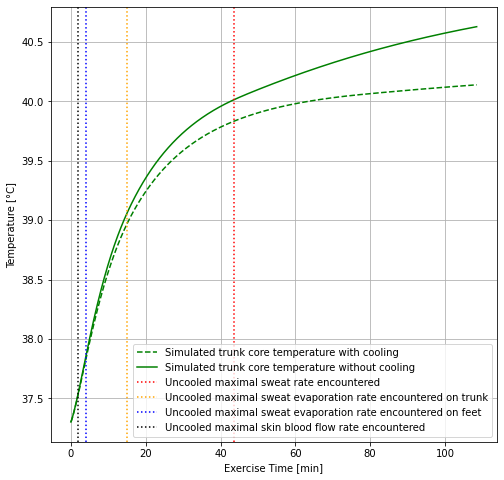

In [14]:
# Plot results
plt.figure(figsize=(8,8))
# Plot trunk core temperature response with and without cooling
plt.plot((ts[int(41.5/60/dt):]-ts[int(41.5/60/dt)])*60,T[int(41.5/60/dt):,trunkcore],color="g",linestyle="--",label="Simulated trunk core temperature with cooling")
plt.plot((ts[int(41.5/60/dt):]-ts[int(41.5/60/dt)])*60,THOT[int(41.5/60/dt):,trunkcore],color="g",label="Simulated trunk core temperature without cooling")
# Plot additional details relevant to base outdoor test case
plt.axvline(x = 43.5, color = 'r', linestyle=":", label = 'Uncooled maximal sweat rate encountered')
plt.axvline(x = 15, color = 'orange', linestyle=":", label = 'Uncooled maximal sweat evaporation rate encountered on trunk')
plt.axvline(x = 4, color = 'b', linestyle=":", label = 'Uncooled maximal sweat evaporation rate encountered on feet')
plt.axvline(x = 2, color = 'k', linestyle=":", label = 'Uncooled maximal skin blood flow rate encountered')

plt.xlabel("Exercise Time [min]")
plt.ylabel("Temperature [°C]")
plt.grid()
plt.legend()
plt.show()

In [15]:
T[int(41.5/60/dt),trunkcore] # Output trunk core temp at beginning of sustained bout

37.29950176641388

In [16]:
# Output trunk core temp rise over first 30 mins of bout
(THOT[int(71.5/60/dt),trunkcore]-T[int(41.5/60/dt),trunkcore]) - (T[int(71.5/60/dt),trunkcore]-T[int(41.5/60/dt),trunkcore]) 

0.15038868299768637

In [17]:
# Output trunk core temp rise over first 45 mins of bout
(THOT[int(86.5/60/dt),trunkcore]-T[int(41.5/60/dt),trunkcore]) - (T[int(86.5/60/dt),trunkcore]-T[int(41.5/60/dt),trunkcore])

0.18342523093867413

In [18]:
# uncooled rate of rise in C/hr over first 45 mins
(THOT[int(86.5/60/dt),trunkcore]-THOT[int(41.5/60/dt),trunkcore])/(45/60)

3.646041170893691

In [19]:
# cooled rate of rise in C/hr over first 45 mins
(T[int(86.5/60/dt),trunkcore]-T[int(41.5/60/dt),trunkcore])/(45/60)

3.402358371143966

In [20]:
# Whole body sweat loss index
np.mean(np.sum(EMASS[int(15/60/dt):int(86.5/60/dt)],axis=1))*1.19/0.75/1.8 # Cooled case
# np.mean(np.sum(EMASSHOT[int(15/60/dt):int(86.5/60/dt)],axis=1))*1.19/0.75/1.8 # Uncooled case

0.8131814267494246

In [21]:
# Manually enter experimental heat extraction for comparison
Lower = np.array([26.60079979,22.9727797,21.17346771,20.39018603,19.72821837,20.44385407,20.62828014,21.46974296,22.24130261,22.94107928,21.92724563,22.60578924,23.93826253,23.30608916,
                21.47984456,21.55672721,22.30684185,23.10414064,23.3344099,23.26125477,22.87825347,24.48119122,24.98767628,23.72631426,21.19230242,22.60756296,24.22507098,
                23.50935369,22.73043369,23.32705671,22.49376801,22.988966,21.00612611,21.87459681,24.28320384,22.17340988,23.2708627,25.19091607,24.80206426,24.4742182,
                24.15874907,25.49351037,24.57862259,24.47684579,24.35849926,23.75482903])

Upper = np.array([54.07591666,36.52394774,33.74931602,33.16203203,33.45669635,32.2728025,34.04157149,32.94182133,33.84406674,33.9533618,36.72028459,35.7494248,36.1822088,
                37.19174278,37.50081392,37.43739794,36.37314059,36.93215291,37.25642637,37.71882594,38.93925885,38.22726727,39.26004887,40.49678867,39.84291669,39.26045108,
                39.65116096,39.84895911,39.70419319,39.43957449,39.43622726,39.87370101,39.74415027,39.36319982,39.02850686,39.28833453,39.96903726,38.62633513,38.11884854,
                39.2840451,41.03410645,39.69972132,39.5972091,40.53216368,39.48902484,38.59599841])

cooling_exp = np.array([40.33835823,29.74836372,27.46139187,26.77610903,26.59245736,26.35832829,27.33492582,27.20578214,28.04268467,28.44722054,29.32376511,29.17760702,
                        30.06023566,30.24891597,29.49032924,29.49706258,29.33999122,30.01814677,30.29541813,30.49004035,30.90875616,31.35422924,32.12386258,32.11155147,
                        30.51760955,30.93400702,31.93811597,31.6791564,31.21731344,31.3833156,30.96499764,31.4313335,30.37513819,30.61889832,31.65585535,30.73087221,31.61994998,
                        31.9086256,31.4604564,31.87913165,32.59642776,32.59661585,32.08791585,32.50450474,31.92376205,31.17541372])

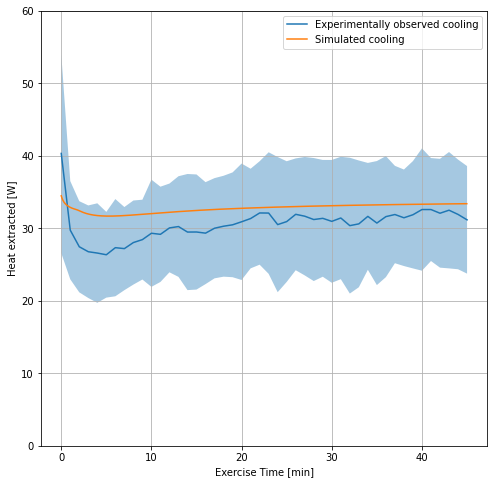

In [22]:
# Plot heat extraction over time
plt.figure(figsize=(8,8))
plt.fill_between(range(0,46), Lower, Upper, alpha=0.4)
plt.plot(range(0,46), cooling_exp, label="Experimentally observed cooling")
plt.plot((ts[int(41.5/60/dt):int(86.5/60/dt)]-ts[int(41.5/60/dt)])*60,1.163*COOLING[int(41.5/60/dt):int(86.5/60/dt)],label="Simulated cooling")
plt.grid()
plt.legend()
plt.xlabel("Exercise Time [min]")
plt.ylabel("Heat extracted [W]")
plt.ylim(0,60)
plt.show()

In [23]:
# Average heat extraction of 45 minute outdoor bout
np.mean(COOLING[int(41.5/60/dt):int(86.5/60/dt)])

28.170590911719618